In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from datetime import datetime as dt
import math

import matplotlib.pyplot as plt

import joblib

In [2]:
g1 = pd.read_csv('data/G(배) 수위#1 (F_CV).csv', header=None)
g1.columns = ['date', 'height1']

g2 = pd.read_csv('data/G(배) 수위#2 (F_CV).csv', header=None)
g2.columns = ['date', 'height2']

In [3]:
merged_df = pd.merge(g1, g2, on='date')
merged_df.info(), merged_df.describe()
merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624769 entries, 0 to 2624768
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   date     object 
 1   height1  float64
 2   height2  float64
dtypes: float64(2), object(1)
memory usage: 60.1+ MB


,date,height1,height2
0,2018-01-01 00:01:00,3.406844,3.416069
1,2018-01-01 00:02:00,3.407356,3.416069
2,2018-01-01 00:03:00,3.407356,3.415812
3,2018-01-01 00:04:00,3.396850,3.416837
4,2018-01-01 00:05:00,3.397362,3.415556
...,...,...,...
2624764,2022-12-31 23:55:00,3.348162,3.365587
2624765,2022-12-31 23:56:00,3.347650,3.366100
2624766,2022-12-31 23:57:00,3.347650,3.366612
2624767,2022-12-31 23:58:00,3.348162,3.365331


In [4]:
merged_df['height1'] < 0, merged_df['height2'] < 0

(0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height1, Length: 2624769, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height2, Length: 2624769, dtype: bool)

In [5]:
merged_df.isna()

,date,height1,height2
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
2624764,False,False,False
2624765,False,False,False
2624766,False,False,False
2624767,False,False,False


In [6]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.set_index('date', inplace=True)

In [7]:
merged_df = merged_df.resample('h').mean()
merged_df.head(), merged_df.tail()

(                      height1   height2
 date                                   
 2018-01-01 00:00:00  3.348297  3.359985
 2018-01-01 01:00:00  3.234691  3.245684
 2018-01-01 02:00:00  3.262332  3.273666
 2018-01-01 03:00:00  3.341030  3.352519
 2018-01-01 04:00:00  3.418892  3.430589,
                       height1   height2
 date                                   
 2022-12-31 19:00:00  3.351357  3.363174
 2022-12-31 20:00:00  3.388206  3.400595
 2022-12-31 21:00:00  3.392613  3.407322
 2022-12-31 22:00:00  3.359262  3.373232
 2022-12-31 23:00:00  3.347927  3.366249)

In [8]:
type(merged_df)

pandas.core.frame.DataFrame

In [9]:
merged_df['height'] = merged_df[['height1', 'height2']].mean(axis=1)
merged_df = merged_df[['height']]
print(merged_df)

                       height
date                         
2018-01-01 00:00:00  3.354141
2018-01-01 01:00:00  3.240187
2018-01-01 02:00:00  3.267999
2018-01-01 03:00:00  3.346774
2018-01-01 04:00:00  3.424741
...                       ...
2022-12-31 19:00:00  3.357266
2022-12-31 20:00:00  3.394401
2022-12-31 21:00:00  3.399968
2022-12-31 22:00:00  3.366247
2022-12-31 23:00:00  3.357088

[43824 rows x 1 columns]


In [10]:
merged_df.isna().sum()

height    63
dtype: int64

In [11]:
merged_df['height'] = merged_df['height'].interpolate(method='polynomial', order=2)

In [12]:
merged_df.isna().sum()

height    0
dtype: int64

In [13]:
start_date = dt(2019, 10, 18, 19, 47)
end_date = dt(2022, 6, 30, 23, 59)

# 주어진 기간 내의 데이터를 sample로 설정
sample_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]

sample_df

,height
date,
2019-10-18 20:00:00,3.495683
2019-10-18 21:00:00,3.560946
2019-10-18 22:00:00,3.630652
2019-10-18 23:00:00,3.706671
2019-10-19 00:00:00,3.794665
...,...
2022-06-30 19:00:00,3.677557
2022-06-30 20:00:00,3.725868
2022-06-30 21:00:00,3.786262


In [14]:
label_df = merged_df[merged_df.index > end_date]
label_df

,height
date,
2022-07-01 00:00:00,3.703716
2022-07-01 01:00:00,3.595909
2022-07-01 02:00:00,3.524294
2022-07-01 03:00:00,3.594451
2022-07-01 04:00:00,3.655630
...,...
2022-12-31 19:00:00,3.357266
2022-12-31 20:00:00,3.394401
2022-12-31 21:00:00,3.399968


In [15]:
training_data_len = math.ceil(len(sample_df) * .8)
training_data_len

train_data = sample_df[:training_data_len].iloc[:, :1]
test_data = sample_df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)

train_data, test_data

(18935, 1) (4733, 1)


(                       height
 date                         
 2019-10-18 20:00:00  3.495683
 2019-10-18 21:00:00  3.560946
 2019-10-18 22:00:00  3.630652
 2019-10-18 23:00:00  3.706671
 2019-10-19 00:00:00  3.794665
 ...                       ...
 2021-12-15 14:00:00  3.511827
 2021-12-15 15:00:00  3.542058
 2021-12-15 16:00:00  3.549255
 2021-12-15 17:00:00  3.545913
 2021-12-15 18:00:00  3.567942
 
 [18935 rows x 1 columns],
                        height
 date                         
 2021-12-15 19:00:00  3.599894
 2021-12-15 20:00:00  3.635790
 2021-12-15 21:00:00  3.686267
 2021-12-15 22:00:00  3.744863
 2021-12-15 23:00:00  3.810160
 ...                       ...
 2022-06-30 19:00:00  3.677557
 2022-06-30 20:00:00  3.725868
 2022-06-30 21:00:00  3.786262
 2022-06-30 22:00:00  3.859257
 2022-06-30 23:00:00  3.820805
 
 [4733 rows x 1 columns])

In [16]:
dataset_train = train_data.height.values
dataset_train = np.reshape(dataset_train, (-1, 1))

dataset_test = test_data.height.values
dataset_test = np.reshape(dataset_test, (-1, 1))

dataset_train.shape, dataset_test.shape

((18935, 1), (4733, 1))

In [17]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

print(scaled_train[:5]), print(*scaled_test[:5])

[[0.85588753]
 [0.87186651]
 [0.88893351]
 [0.90754602]
 [0.92909061]]
[0.88140255] [0.89019145] [0.90255032] [0.91689699] [0.93288434]


(None, None)

In [18]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_train.shape, y_train.shape

(torch.Size([18911, 24, 1]), torch.Size([18911, 1]))

In [19]:
sequence_length = 24
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_test.shape, y_test.shape

(torch.Size([4709, 24, 1]), torch.Size([4709, 1]))

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x): # defines forward pass of the neural network
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.004)

print(model)

c:\Users\user\anaconda\envs\py3_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LSTMModel(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [23]:
batch_size = 64
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		# print(batch_X.shape) # torch.Size([64, 50, 1])
		# print(batch_y.shape) # torch.Size([64, 1])
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
		
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0003, Test Loss: 0.0001
Epoch [20/50] - Training Loss: 0.0003, Test Loss: 0.0003
Epoch [30/50] - Training Loss: 0.0002, Test Loss: 0.0001
Epoch [40/50] - Training Loss: 0.0002, Test Loss: 0.0001
Epoch [50/50] - Training Loss: 0.0002, Test Loss: 0.0002


In [25]:
model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        predictions_test = model(batch_X_test)
        preds.append(predictions_test.cpu().numpy())

preds = np.concatenate(preds, axis=0)
preds = preds.reshape(-1, 1)

In [26]:
# 역변환하여 실제 값으로 변환
actual = scaler.inverse_transform(y_test.cpu().numpy())
predicted = scaler.inverse_transform(preds)

In [27]:
# 테스트 구간의 날짜를 가져오기
dates = test_data.index[sequence_length:]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': actual.flatten(),
    'Predicted': predicted.flatten()
})

print(comparison_df)

                    Date    Actual  Predicted
0    2021-12-16 19:00:00  3.436246   3.422224
1    2021-12-16 20:00:00  3.484479   3.475589
2    2021-12-16 21:00:00  3.525142   3.540520
3    2021-12-16 22:00:00  3.554536   3.583798
4    2021-12-16 23:00:00  3.615047   3.608812
...                  ...       ...        ...
4704 2022-06-30 19:00:00  3.677557   3.682581
4705 2022-06-30 20:00:00  3.725868   3.743418
4706 2022-06-30 21:00:00  3.786262   3.788649
4707 2022-06-30 22:00:00  3.859257   3.841506
4708 2022-06-30 23:00:00  3.820805   3.880468

[4709 rows x 3 columns]


In [31]:
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'LSTM RMSE: {rmse:.4f}')

LSTM RMSE: 0.0503


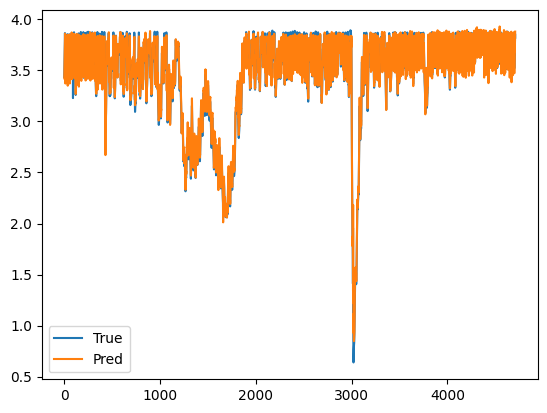

In [35]:
plt.plot(actual, label = 'True')
plt.plot(predicted, label = 'Pred')
plt.legend()
plt.show()

In [28]:
# # Define the number of future time steps to forecast
# num_forecast_steps = 1

# # Convert to NumPy and remove singleton dimensions
# sequence_to_plot = X_test.squeeze().cpu().numpy()

# historical_data = sequence_to_plot[-1]
# # print(historical_data.shape)

# # Initialize a list to store the forecasted values
# forecasted_values = []

# # Use the trained model to forecast future values
# with torch.no_grad():
#     for _ in range(num_forecast_steps):
#         historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
#         predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
#         forecasted_values.append(predicted_value)
#         historical_data = np.roll(historical_data, shift=-1)
#         historical_data[-1] = predicted_value

# forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))
# print("예측값", forecasted_values)

# # Generate futute dates
# last_date = test_data.index[-1]
# print("마지막 날짜", last_date)
# future_dates = pd.date_range(start=last_date+pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')
# print("예측 날짜", future_dates)

In [29]:
# # 테스트 데이터의 마지막 num_forecast_steps 만큼
# actual_values = test_data.iloc[-num_forecast_steps:].values
# print("실제 값", actual_values)

# # RMSE 계산
# rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
# print(f'LSTM RMSE: {rmse:.4f}')

In [30]:
PATH = "model.pth"
torch.save(model, PATH)
print(f"Model saved to {PATH}")

Model saved to model.pth
